In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 28 June 2023
# Description:
#     this script obtain and save the 1500m isobath contour variables, which is used for the 
#     cross-shelf heat transport estimates

# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')


In [2]:
client = Client(n_workers=56,threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 56
Total threads: 56,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42045,Workers: 56
Dashboard: /proxy/8787/status,Total threads: 56
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44441,Total threads: 1
Dashboard: /proxy/42209/status,Memory: 0 B
Nanny: tcp://127.0.0.1:44203,


In [3]:
%%time

# load ice draft to create masks
di = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr10_diag_daily/ocean_avg_0001.nc')
ice_draft = di.variables["zice"]

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
mask_zice_1000 = ma.masked_where(ice_draft < -1000, np.ones(ice_draft.shape))
di.close()

dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom4_frc/waom4extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
lat_u = dg.variables["lat_u"]
lon_u = dg.variables["lon_u"]
lat_v = dg.variables["lat_v"]
lon_v = dg.variables["lon_v"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
h = dg.variables["h"]

# ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
# ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset

area=np.divide(1,pm*pn)

## creating the contour, such as a isobath, and extracting the coordinates using matplotlib's Path class
# based on https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Cross-contour_transport.ipynb

h = dg.h.load()

h = h*mask_zice

# Fill in land with zeros:
h = h.fillna(0)

# same but getting ice draft contours now:
zice = dg.zice.load()
zice = zice*mask_zice_1000

# Fill in land with zeros:
zice = zice.fillna(0)

contour_depth = -.01

## Choose whether you want your contour on the u or t grid.
grid_sel = 't'
if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho
 



CPU times: user 9.06 s, sys: 3.77 s, total: 12.8 s
Wall time: 24 s


# plot contours below

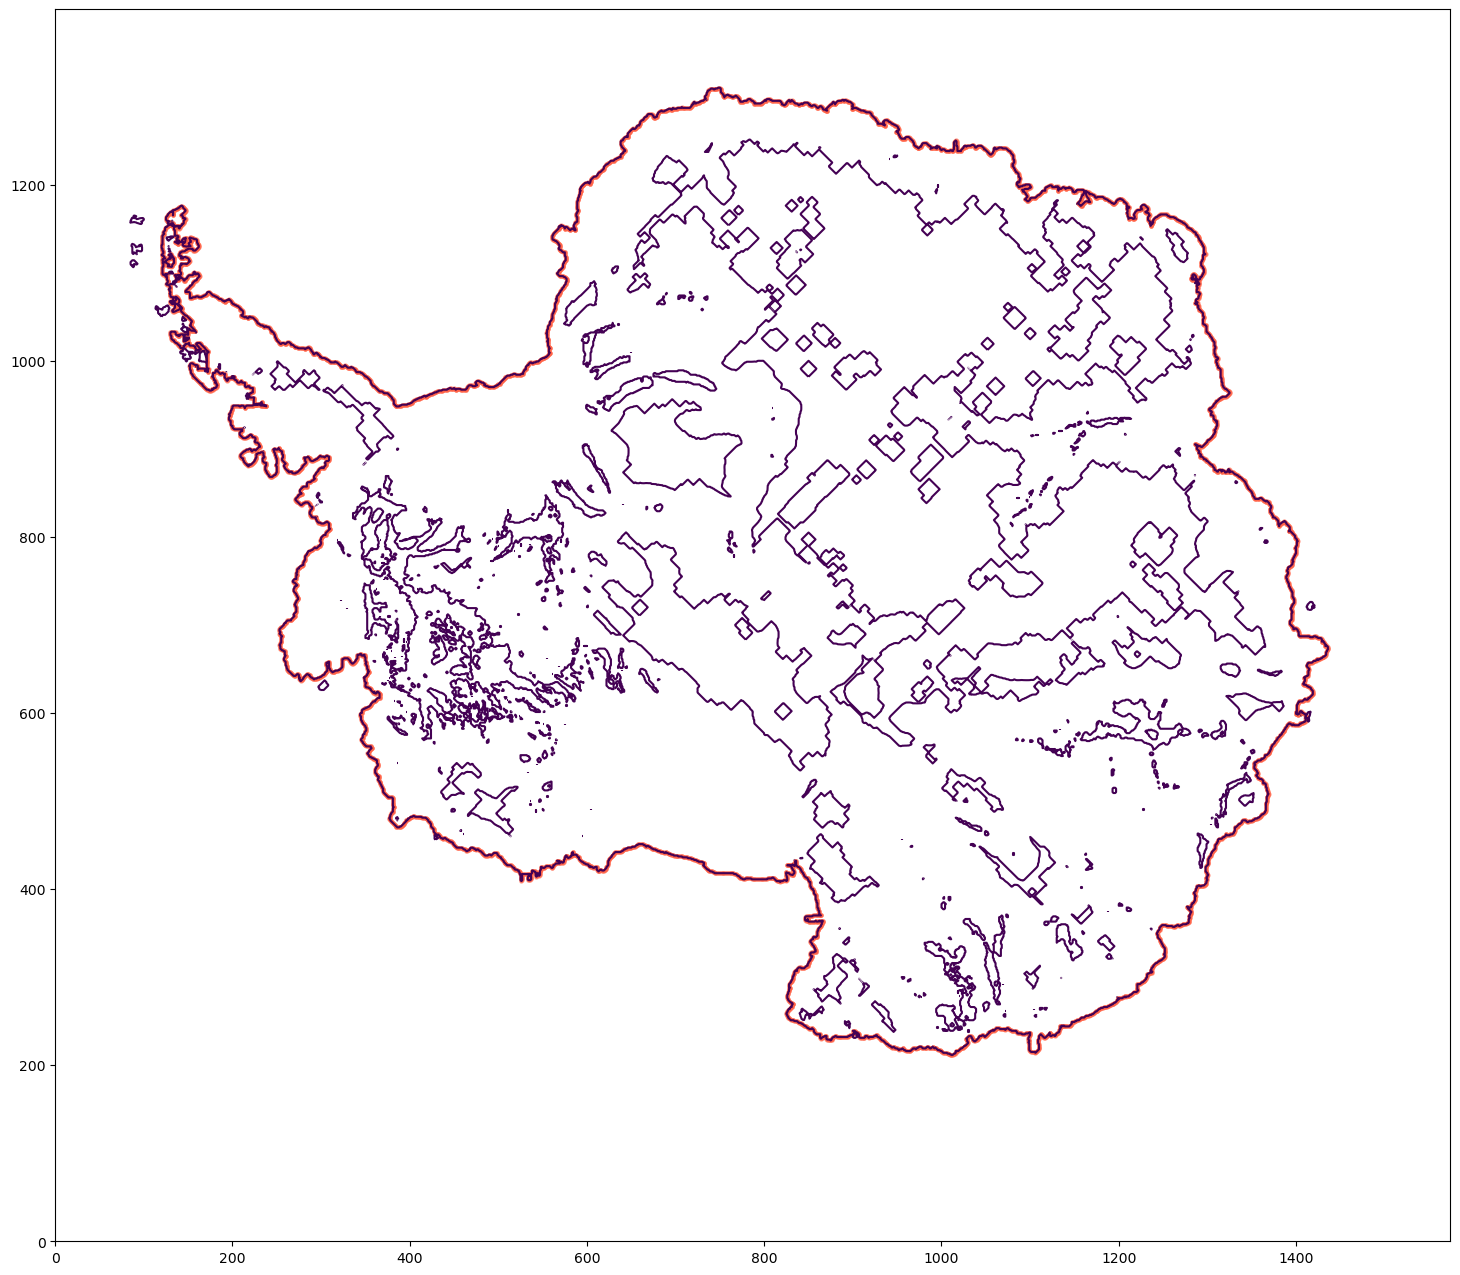

In [4]:
fig = plt.figure(figsize = (18, 16))
count = 0
x_contour = []
y_contour = []

# Create the contour:
sc = plt.contour(zice, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        
        count += 1
        
        if count == 1:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

xi=0 
xf=8805
plt.scatter(x_contour[xi:xf], y_contour[xi:xf], s=5, alpha=0.5, color='tomato');
# plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');
# plt.xlim(1000,1100)
# plt.ylim(0,300)

In [5]:
x_contour = x_contour[xi:xf]
y_contour = y_contour[xi:xf]
len(x_contour)

8805

(0.0, 300.0)

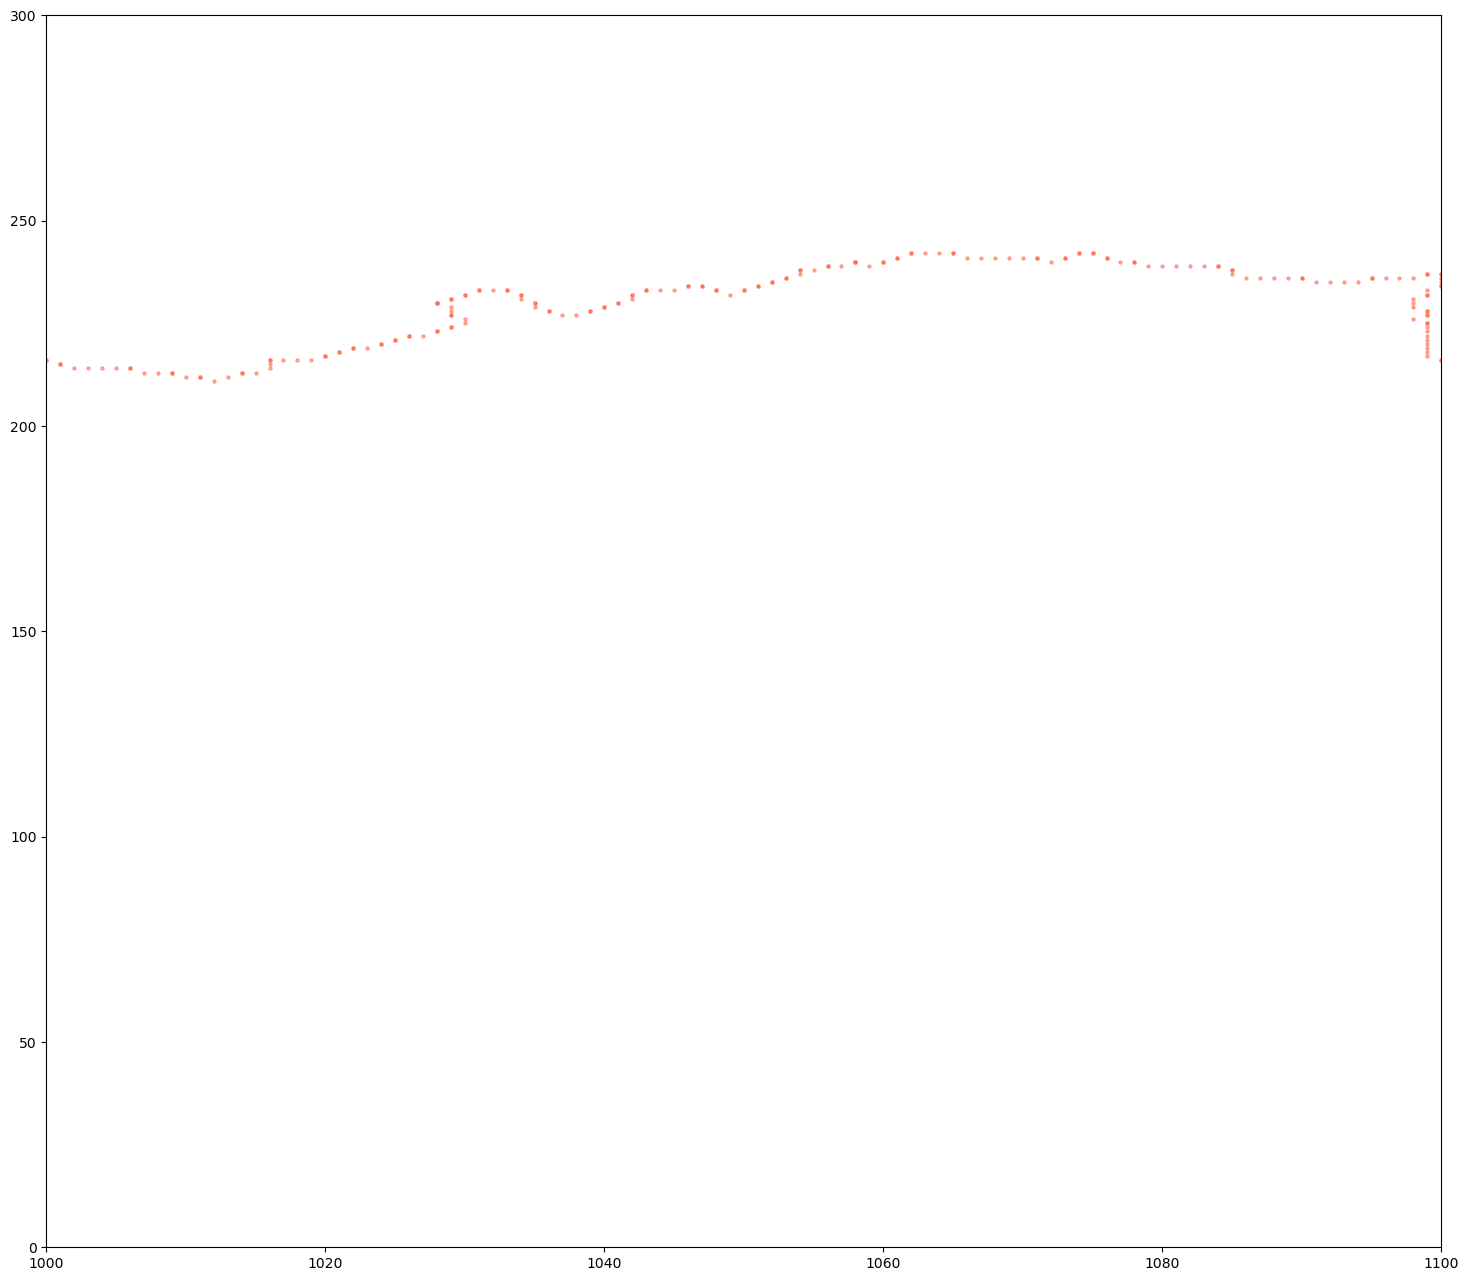

In [6]:
fig = plt.figure(figsize = (18, 16))

plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');
plt.xlim(1000,1100)
plt.ylim(0,300)

In [7]:
# save x_contour, y_contour

xcon_np = np.asarray(x_contour)
np.savetxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM4_CF_x_contour.csv", xcon_np, delimiter=",")

ycon_np = np.asarray(y_contour)
np.savetxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM4_CF_y_contour.csv", ycon_np, delimiter=",")


### testing loading contour back:

In [8]:
fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/'
xcon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM4_CF_x_contour.csv")
x_contour = xcon_np.tolist()
ycon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM4_CF_y_contour.csv")
y_contour = ycon_np.tolist()

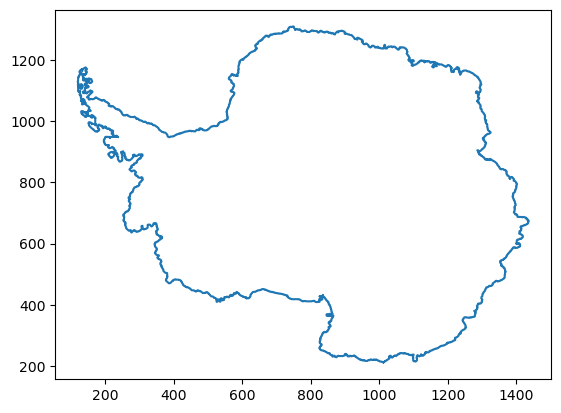

In [9]:
plt.plot(x_contour,y_contour)
# plt.xlim(1000,1100)
# plt.ylim(0,300)

#### calculate vol_transp here for testing - are the cross-contour transports correct?


In [10]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

print(diff_ind)

# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[int(y_contour[ii]), int(x_contour[ii])]

[1, 4, 8, 14, 16, 19, 23, 25, 27, 28, 31, 33, 34, 36, 40, 42, 44, 46, 52, 54, 57, 60, 62, 65, 68, 70, 72, 80, 83, 85, 86, 90, 93, 95, 99, 101, 102, 106, 108, 111, 113, 116, 118, 120, 122, 125, 128, 131, 135, 137, 140, 146, 149, 151, 154, 166, 168, 170, 173, 175, 178, 179, 181, 184, 186, 190, 193, 208, 210, 213, 215, 217, 221, 229, 232, 235, 237, 244, 250, 252, 256, 258, 260, 261, 266, 269, 271, 273, 276, 278, 281, 285, 287, 292, 297, 299, 302, 305, 309, 312, 316, 320, 324, 326, 328, 331, 333, 336, 343, 347, 352, 353, 359, 361, 364, 367, 371, 374, 379, 382, 383, 387, 392, 396, 398, 400, 403, 407, 410, 412, 415, 418, 420, 429, 432, 435, 438, 441, 443, 446, 448, 452, 455, 460, 462, 464, 466, 473, 477, 479, 481, 484, 488, 490, 493, 496, 497, 502, 503, 515, 516, 532, 543, 544, 546, 551, 555, 562, 566, 573, 575, 580, 583, 587, 594, 598, 601, 603, 606, 609, 612, 614, 617, 620, 622, 624, 627, 634, 636, 644, 646, 647, 654, 655, 660, 663, 666, 668, 673, 675, 676, 680, 682, 686, 687, 692, 700, 70

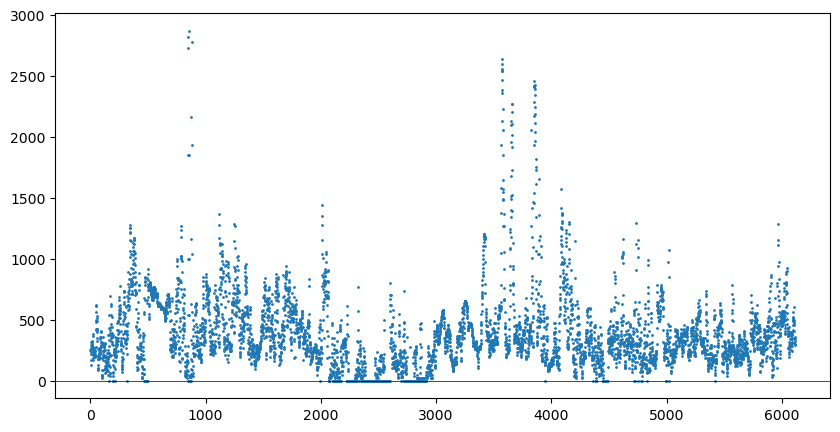

In [11]:
fig = plt.figure(figsize=(10, 5))

plt.plot(h_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

In [12]:
# Get lat/lon along the contour

# Choose whether you want your contour on the u or t grid.
grid_sel = 't'

if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 'v':
    x_var = lon_v
    y_var = lat_v
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho

lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[int(y_contour[ii-1]),int(x_contour[ii-1])]
    lat_along_contour[ii] = y_var[int(y_contour[ii-1]),int(x_contour[ii-1])]

# Repeat the leftmost point at the end of the array.
# (Required for masking contour above and below)

lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

# Number of grid points on the contour
num_points = len(lat_along_contour)

# Now we number the points along the contour
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    # lat1 = lat_along_contour[ii] # these aren't being used:
    # lat2 = lat_along_contour[ii+1]
    # lon1 = lon_along_contour[ii]
    # lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii

contour_mask = h*0

In [13]:
#Create mask
#Now we create a mask below contour so that the direction of the contour can be determined

#Remark on computational inefficiency:
#Note that creating masks with nested for loops is very inefficient. We should probably use boolean masks (just compare the entire array with mask_value), and DataArray.shift() or DataArray.roll() from each of the directions to generate the masks without using loops.
#See discussion in: https://github.com/COSIMA/cosima-recipes/issues/179


for ii in range(num_points-1):
    contour_mask[int(y_contour[ii]), int(x_contour[ii])] = contour_mask_numbered[ii]+1
mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value # this makes pt x=0, y=-1 equal to -1000
# then this will be the first point to enter in the fiirst IF-case in the next cell;

print(contour_masked_above.shape, contour_mask_numbered.shape)
print(contour_masked_above[-20:-1, 0])

(1400, 1575) (1400, 1575)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
#from top left:
for ii in range(len(contour_mask[0,:])-1): #x: len(x-axis) - 1 (=629)
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]: #y: len(y-axis) (=560)[from end to start, inverse order][from first to (end-1)]
        if contour_masked_above[jj, ii] == mask_value: # if north of contour line
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero (= south of contour line)
                contour_masked_above[jj-1, ii] = mask_value # make it -1000
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value # make it -1000

#from top right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask[0,:])-1):
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value

In [16]:
# save contour_masked_above
files_path = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
contour_masked_above.dump(files_path + 'WAOM4_contour_masked_above_CF')